# Source Models

This notebook explores some of the simple source models commonly used in seismology, which take the general from of:

\begin{equation*}
\Omega(f) = \frac{\Omega_{0}}{(1 + \frac{f}{f_{c}}^{\lambda n})^{1/\lambda}}
\end{equation*}

where $\lambda$ and $n$ vary based on the model. A few we will explore here are:

1. $\omega^{2}$ model (Brune 1970, 1971), $\lambda = 1, n = 2$


2. The modified $\omega^{2}$ model (Boatwright 1980), $\lambda = 2, n = 2$


3. The $\omega^{3}$ model (Haskell 1964) $\lambda = \frac{2}{3}, n = 3$


Let's first get some standard imports and function definitions out of the way:

In [1]:
%matplotlib inline
# general imports
from functools import partial

import numpy as np
import matplotlib.pyplot as plt


# define generic source spectrum
def get_source_spectrum(f: np.array, omega_0: float, fc: float, 
                        lam: float, n: float, output="DISP") -> np.array:
    """
    Return a theoretical source spectrum for input frequencies f
    """
    # set constant for differentiation in order
    if output == 'DISP':  # using displacement
        const = 1
    elif output == 'VEL':  # using velocity
        const = 2j * np.pi * f / (2 * np.max(f))
    elif output == 'ACC':  # using accleration
        const = (2j * np.pi * f / (2 * np.max(f))) ** 2 
    # return
    return np.abs((const * omega_0) / (1 + (f / fc)**(lam * n))**(1 / lam))

In [2]:
# define specific models using partial functions
source_models = dict(
w2=partial(get_source_spectrum, lam=1, n=2),
modified_w2=partial(get_source_spectrum, lam=2, n=2),
w3=partial(get_source_spectrum, lam=2./3, n=3),
)

In [3]:
# function for calculating spectrum
def calc_spectra(f, omega_0, fc, output="DISP") -> dict:
    """ Calculate spectrum for all models in source model dict. """

    # calculate spectra and return dict
    return {i: func(f=f, omega_0=omega_0, fc=fc, output=output)
            for i, func in source_models.items()}


def ifft_spectra(spect_dict: dict) -> dict:
    """ Make some assumptions to calculate the ifft of the source spectra. """
    out = {}
    for label, spectrum in spect_dict.items():
        assumed_phase = np.random.uniform(low=-1, high=1)  #2 * np.pi  #np.linspace(0, 2 * np.pi, len(spectrum))
        spec_i = 1j * np.sin(assumed_phase) * spectrum
        spec = np.cos(assumed_phase) * spectrum
        out[label] = np.fft.irfft(spec_i + spec)
    return out


def plot_spectrum(f, spect_dict, log=True, ylabel='displacement amplitude'):
    func = plt.loglog if log else plt.plot
    for i, values in spect_dict.items():
        func(f, values, label=i)
    plt.legend()
    plt.xlabel('frequency (Hz)')
    plt.ylabel(ylabel)
    return plt.gca()


def plot_time_domain(f, spect_dict, ylabel='displacement amplitude'):
    for i, values in spect_dict.items():
        t = np.linspace(0, np.max(f) * 2, len(values))
        plt.plot(t, values, label=i)
    plt.legend()
    plt.xlabel('Time (seconds)')
    plt.ylabel(ylabel)
    return plt.gca()

Next we plot these models for a constant corner frequencies ($f_{c}$) and low-frequency spectral level ($\Omega_{0}$) in order to get a conceptual understanding for how they behave. Classically the displacement is plotted a log_log plot, but we will plot all ground motion types with log log and linear plots.

In [4]:
# Make plots for simple case
sampling_rate = 500  # sampling rate of instrument
duration = 0.5  # duration in seconds

f = np.fft.rfftfreq(int(sampling_rate * duration), d=1./sampling_rate)
case_1_disp = calc_spectra(f, 5000, 10)
case_1_vel = calc_spectra(f, 5000, 10, output='VEL')
case_1_acc = calc_spectra(f, 5000, 10, output='ACC')

figsize = (18, 4)

<AxesSubplot:xlabel='frequency (Hz)', ylabel='acceleration amplitude'>

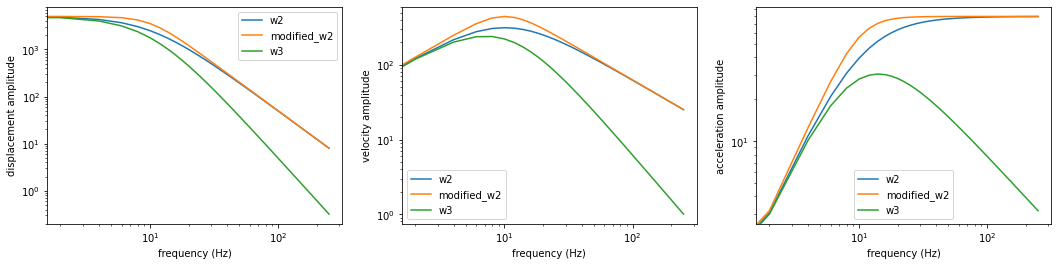

In [5]:
# log_log plots
plt.figure(figsize=figsize)
plt.subplot(1, 3, 1)
plot_spectrum(f, case_1_disp)
plt.subplot(1, 3, 2)
plot_spectrum(f, case_1_vel, ylabel='velocity amplitude')
plt.subplot(1, 3, 3)
plot_spectrum(f, case_1_acc, ylabel='acceleration amplitude')

<AxesSubplot:xlabel='frequency (Hz)', ylabel='acceleration amplitude'>

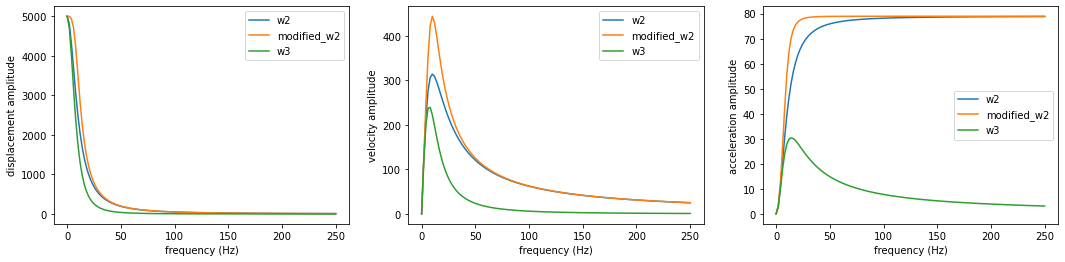

In [6]:
# linear plots
plt.figure(figsize=figsize)
plt.subplot(1, 3, 1)
plot_spectrum(f, case_1_disp, log=False)
plt.subplot(1, 3, 2)
plot_spectrum(f, case_1_vel, log=False, ylabel='velocity amplitude')
plt.subplot(1, 3, 3)
plot_spectrum(f, case_1_acc, log=False, ylabel='acceleration amplitude')
